In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style('whitegrid')
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['legend.frameon'] = True
palette = sns.color_palette('Set1')
sns.set_palette(palette)

# Download and read the data

The issue is to predict a full year worth of sales for 4 items from two competing stores located in six different countries.

In [3]:
!kaggle competitions download -p data -c tabular-playground-series-sep-2022 -q
!cd data && jar xf tabular-playground-series-sep-2022.zip && del *.zip

In [4]:
df_train = pd.read_csv('data/train.csv', index_col='row_id')
df_test = pd.read_csv('data/test.csv', index_col='row_id')
df_train.shape, df_test.shape

((70128, 5), (17520, 4))

In [5]:
dfs = {'train': df_train, 'test': df_test}
for _, df in dfs.items():
    df.rename({'product': 'item'}, axis=1, inplace=True)

In [6]:
df_train

,date,country,store,item,num_sold
row_id,,,,,
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240
...,...,...,...,...,...
70123,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614
70124,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,215
70125,2020-12-31,Spain,KaggleRama,Kaggle Getting Started,158


In [7]:
df_train.isna().sum()

date        0
country     0
store       0
item        0
num_sold    0
dtype: int64

# Brief target analysis

First of all, let's take a look at the target variable.

I just want to explore target distributions with references to store, country and item.

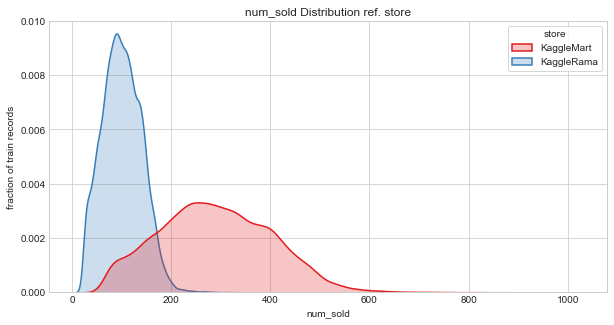

In [8]:
sns.kdeplot(data=df_train, x='num_sold', hue='store', fill=True, linewidth=1.5, common_norm=False)
plt.xlabel('num_sold')
plt.ylabel('fraction of train records')
plt.title('num_sold Distribution ref. store')
plt.show()

Which shop sold the most in percents?

In [9]:
df_train.groupby('store')['num_sold'].sum() / df_train.num_sold.sum() * 100

store
KaggleMart    74.251484
KaggleRama    25.748516
Name: num_sold, dtype: float64

The difference between stores' sales is 3 times. Suppose that KaggleMart store is bigger. This must be taken into account in further analysis.

Now let's find out how many books were sold in each country in each store for all the time with respect to the stores' sales imbalance.

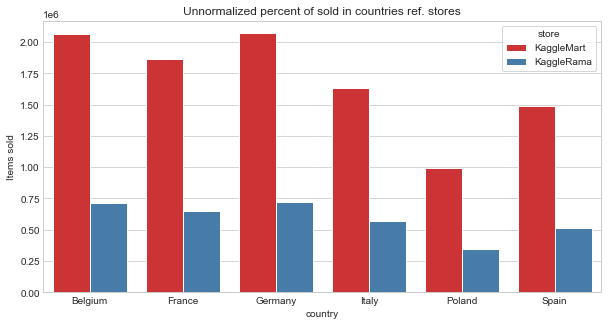

In [10]:
sns.barplot(data=df_train, x='country', y='num_sold', hue='store', estimator=np.sum, ci=None)
plt.ylabel('Items sold')
plt.title('Unnormalized percent of sold in countries ref. stores')
plt.show()

In [11]:
def get_norm_data(df):
    dftmp_norm = df.copy()
    dftmp_norm['sold_percent'] = dftmp_norm.num_sold

    for store in df.store.unique():
        inds = df[df.store == store].index
        sold_over_store = df.loc[inds].num_sold.sum()
        dftmp_norm.loc[inds, 'sold_percent'] /= sold_over_store / 100
    return dftmp_norm
        
df_train_norm = get_norm_data(df_train)

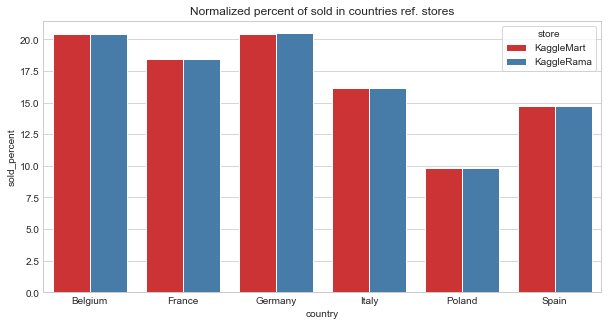

In [12]:
sns.barplot(data=df_train_norm, x='country', y='sold_percent', hue='store', estimator=np.sum, ci=None)
plt.title('Normalized percent of sold in countries ref. stores')
plt.show()

In [13]:
df_train_norm.groupby(['country', 'store']).sold_percent.sum()

country  store     
Belgium  KaggleMart    20.401564
         KaggleRama    20.435839
France   KaggleMart    18.438966
         KaggleRama    18.435785
Germany  KaggleMart    20.443561
         KaggleRama    20.467648
Italy    KaggleMart    16.160946
         KaggleRama    16.134055
Poland   KaggleMart     9.850469
         KaggleRama     9.832046
Spain    KaggleMart    14.704494
         KaggleRama    14.694626
Name: sold_percent, dtype: float64

KaggleMart had been selling more items quantitatively, but in percentage score both stores' sales are equivalent. Probably we will see the same thing with the items.

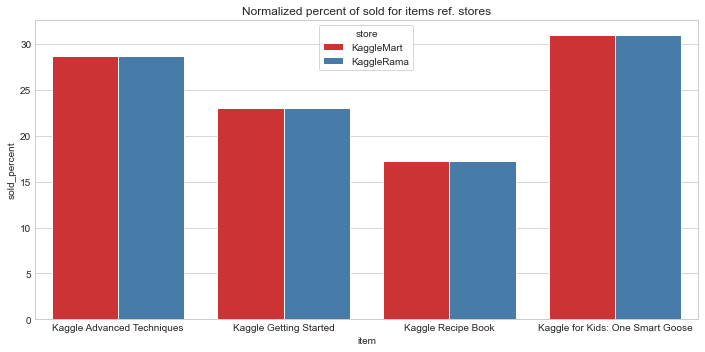

In [14]:
sns.barplot(data=df_train_norm, x='item', y='sold_percent', hue='store', estimator=np.sum, ci=None)
plt.title('Normalized percent of sold for items ref. stores')
plt.tight_layout()
plt.show()

In [15]:
df_train_norm.groupby(['item', 'store']).sold_percent.sum()

item                              store     
Kaggle Advanced Techniques        KaggleMart    28.721914
                                  KaggleRama    28.732173
Kaggle Getting Started            KaggleMart    23.021573
                                  KaggleRama    23.023340
Kaggle Recipe Book                KaggleMart    17.251341
                                  KaggleRama    17.228769
Kaggle for Kids: One Smart Goose  KaggleMart    31.005172
                                  KaggleRama    31.015718
Name: sold_percent, dtype: float64

To sum up, both stores had been selling books in the same scheme in the same relative volume: KaggleMart sold three times more items than KaggleRama, so it is reasonable to believe that supply of the first was three times larger.

# Time features analysis

Now we should extract the concrete time features (month, day, year) from the data feature.

In [16]:
for _, df in dfs.items():
    df.date = pd.to_datetime(df.date, infer_datetime_format=True)
    df['dayofyear'] = df.date.dt.dayofyear  # day of the year
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['daynum_th'] = df.date.dt.day  # day of the month
    df['weekday'] = df.date.dt.weekday  # day of the week
    df['yearweek'] = df.date.dt.isocalendar().week  # week of the year

In [17]:
df_train

,date,country,store,item,num_sold,dayofyear,year,month,daynum_th,weekday,yearweek
row_id,,,,,,,,,,,
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663,1,2017,1,1,6,52
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615,1,2017,1,1,6,52
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480,1,2017,1,1,6,52
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710,1,2017,1,1,6,52
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240,1,2017,1,1,6,52
...,...,...,...,...,...,...,...,...,...,...,...
70123,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614,366,2020,12,31,3,53
70124,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,215,366,2020,12,31,3,53
70125,2020-12-31,Spain,KaggleRama,Kaggle Getting Started,158,366,2020,12,31,3,53


How many books were sold for all years presented?

In [18]:
df_train.groupby(['year']).num_sold.sum()

year
2017    3112163
2018    3425424
2019    3232879
2020    3855193
Name: num_sold, dtype: int64

In [19]:
df_train_norm = get_norm_data(df_train)
dfs['norm'] = df_train_norm

Now let's explore seasonal factor. I will present plottings with sum and mean aggregations.

In [20]:
def plot(plotting_func, data_norm, x,
         hue=None, kwargs={'kind': 'point', 'linestyles':['--', '--']}, figsize=(12, 6), transpose=False):
    
    if not transpose:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, squeeze=True, figsize=figsize)
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, squeeze=True, figsize=figsize)
        
    plotting_func(data=data_norm, x=x, **kwargs, y='num_sold', estimator=np.mean, ax=ax1)
    plotting_func(data=data_norm, x=x, hue=hue, **kwargs, y='sold_percent', estimator=np.sum, ax=ax2)
    
    ax1.set_title('mean num_sold - {}'.format(x))
    ax2.set_title('percent sum of sales - {}'.format(x))
    ax1.set_ylabel('mean num_sold')
    ax2.set_ylabel('percents sold (%)')
    
    if len(data_norm[x].unique()) > 55:
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize=5)
        ax2.set_xticklabels(ax1.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize=5)
        plt.tight_layout()
    plt.show()

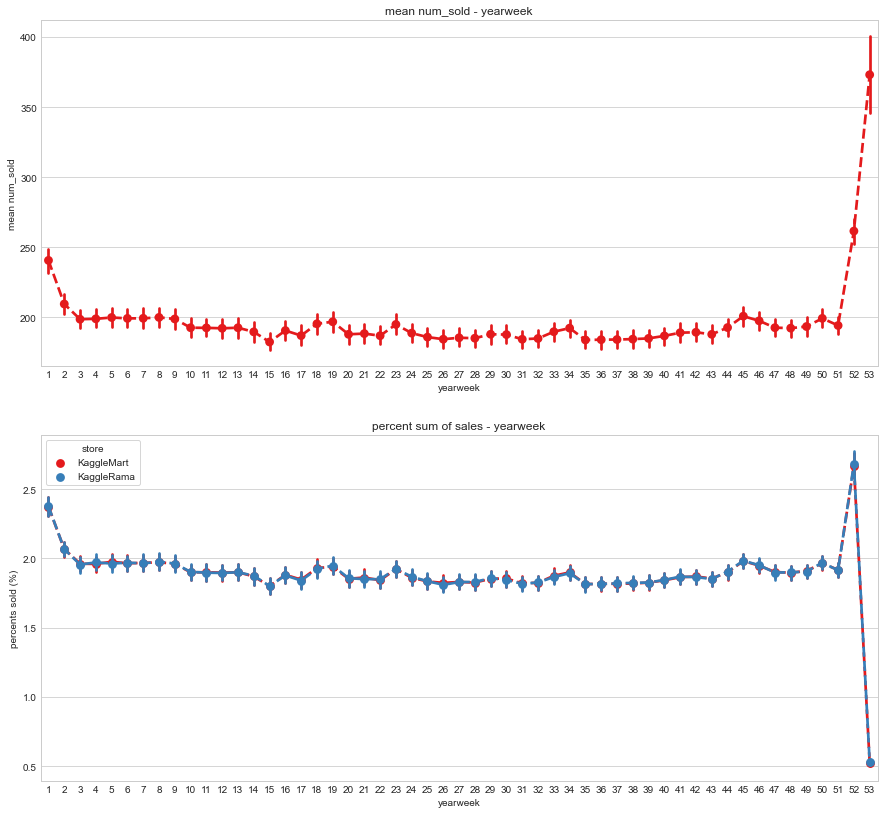

In [21]:
plot(sns.pointplot, df_train_norm, 'yearweek', hue='store', transpose=True, figsize=(15, 14))

We can see an unordinary tendency: on the one chart, the mean number of books sold increases at the end of the year, and on the other, the total percentage of books sold drops extremely. This is probably caused by the number of sales.

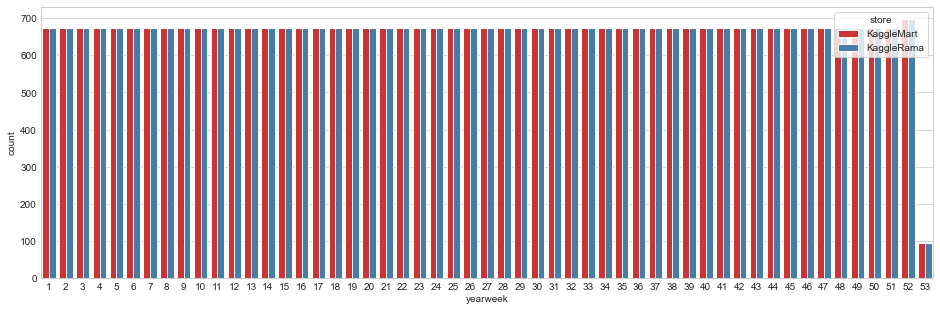

In [22]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.countplot(data=df_train_norm, x='yearweek', hue='store', ax=ax)
plt.show()

Indeed, everything is gone as supposed. This effect can be explained by the fact that customers buy less books at the end of the year in a quantitative volume, but the average cheque contains more books. So it is worth adding a new feature characterizing the holyday week of the new year.

In [23]:
for _, df in dfs.items():
    df['is_ny_holyday'] = (df.yearweek == 53).astype(int)

Now let's study sales' dynamics changing from month to month in relation to the year.

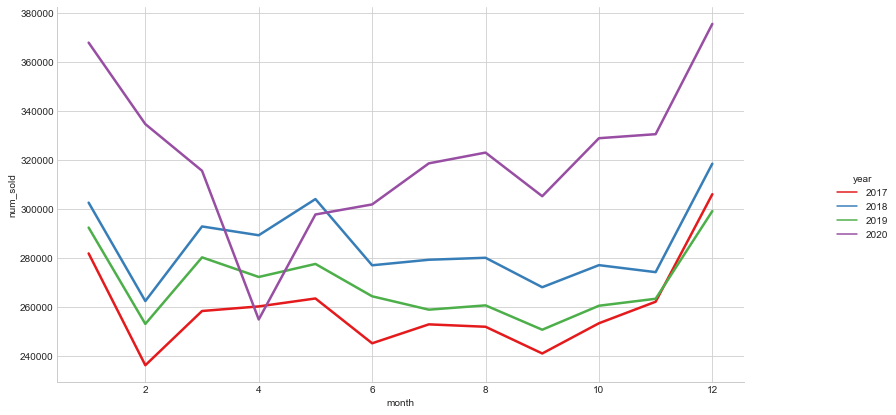

In [24]:
dfg = df_train_norm.groupby(['year', 'month'], as_index=False)['num_sold'].sum()
g = sns.relplot(data=dfg, x='month', y='num_sold', hue='year', kind='line',
                linewidth=2.5, palette=sns.color_palette(n_colors=4))
g.figure.set_size_inches(14, 6)
plt.show()

<!-- 2020 год заметно отличается от остальных. Во-первых, в течение этого года было продано больше всего книг, что объясняет сдвиг графика вверх. Во-вторых, существуют и другие тенденции. У каждого года наибольшее число продаж приходится на декабрь и январь, начиная с августа тренды идентичны. Отличие 2020 в том, что с начала января продажи падали до нижней точки в апреле, в то время как у других она локализуется в феврале. Вероятно, такой тренд связан с проводимой в этом году длительной акцией.
 
Стоит отметить, что признак года как правило не учитывается при моделировании, так как модель, обученная на 2017-2020 годах при получении 2021 года не сможет проинтерпретировать значение признака. Добавим признак, который выступает в роли индикатора 2020 года, и дальнейший анализ будет строить по наборам данных по годам.-->

2020 is noticeably different from the others. Firstly, the most of books was sold during this year, which explains the upward shift in the lineplot.

Secondly, there are other trends. Each year the largest number of sales occurs in December and January, since August the trends are identical. The specificity of 2020 is that since the beginning of January sales have fallen to the lowest point in April, while for others the bottom value is localized in February. This trend is probably related to the long-term promotion carried out this year.

It's worth mentioning that year feature is usually untaken when modeling, because the model learnt on 2017-2020 years will not correctly handle e.g. 2021. 

Let's add new feature as 2020 year indicator.

In [25]:
for _, df in dfs.items():
    df['is_2020'] = (df.year == 2020).astype(int)

Observe sales' dynamics over the month's days.

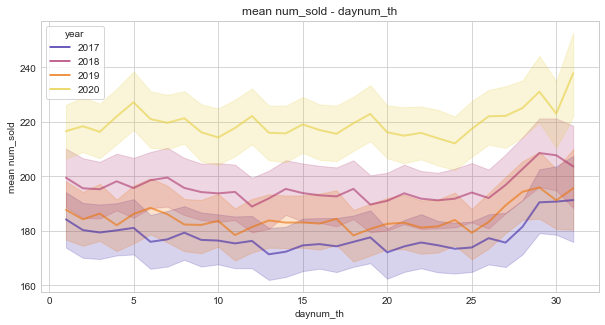

In [26]:
sns.lineplot(data=df_train_norm, x='daynum_th', y='num_sold', hue='year',
             estimator=np.mean, alpha=0.6, linewidth=2, palette=sns.color_palette('CMRmap', n_colors=4))
plt.ylabel('mean num_sold')
plt.title('mean num_sold - daynum_th')
plt.show()

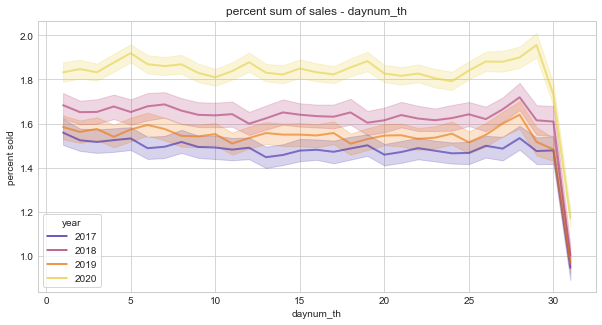

In [27]:
sns.lineplot(data=df_train_norm, x='daynum_th', y='sold_percent', hue='year',
             estimator=np.sum, alpha=0.6, linewidth=2, palette=sns.color_palette('CMRmap', n_colors=4))
plt.ylabel('percent sold')
plt.title('percent sum of sales - daynum_th')
plt.show()

<!-- Как видно на графиках, особых инсайтов нет: тенденции идентичны для каждого года. Заметно, что объем продаж падает к концу месяца, однако среднее значение проданных книг немного меняется.

Падание объема продаж здесь можно объяснить сдвигом, вызванным декабрем. Проанализируем отдельно месяца. -->

As it can be seen from the lineplots, there are no notable insights: the tendencies are identical for any year. It is noticeable, that sales' volume drops to the end of the month, but the mean number of items sold varies quite slightly.

The sales' volume fall can be explained by the shift, caused by December trends. Let's take a clear look.

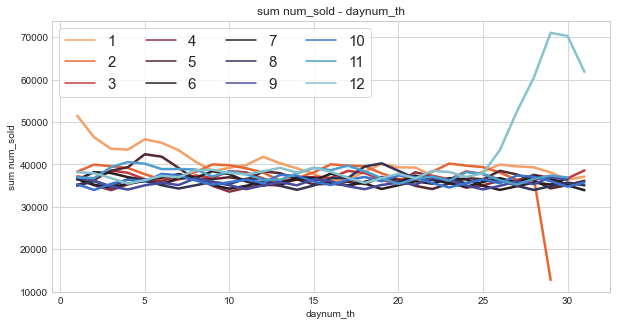

In [28]:
sns.lineplot(data=df_train_norm, x='daynum_th', y='num_sold', hue='month',
             estimator=np.sum, ci=None, linewidth=2.5, palette=sns.color_palette('icefire_r', n_colors=12))
plt.ylabel('sum num_sold')
plt.title('sum num_sold - daynum_th')
plt.legend(ncol=4, fontsize=15)
plt.show()

As expected, the major shift is brought by the December's last week. There is also a shift of undefined nature at the end of February when the sales drop.

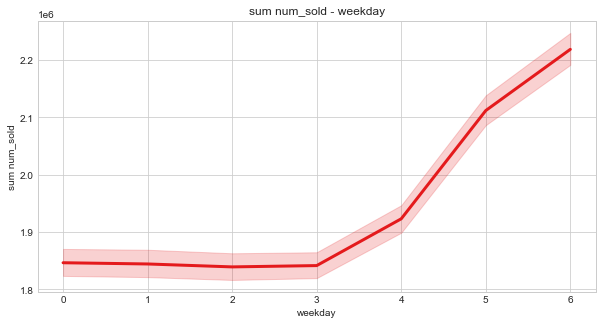

In [29]:
sns.lineplot(data=df_train_norm, x='weekday', y='num_sold', estimator=np.sum, linewidth=3)
plt.ylabel('sum num_sold')
plt.title('sum num_sold - weekday')
plt.show()

The sales increase by the end of the week, starting from Wednesday. Previously there are no significant changes in the volume being sold.

# Item features analysis

<!-- Теперь можно строить анализ вокруг продаваемых объектов. -->
Now it's time to carry analysis around items. For example, let's look at which books are the most popular.

In [30]:
df_train_norm.groupby(['item', 'store'])['sold_percent'].sum()

item                              store     
Kaggle Advanced Techniques        KaggleMart    28.721914
                                  KaggleRama    28.732173
Kaggle Getting Started            KaggleMart    23.021573
                                  KaggleRama    23.023340
Kaggle Recipe Book                KaggleMart    17.251341
                                  KaggleRama    17.228769
Kaggle for Kids: One Smart Goose  KaggleMart    31.005172
                                  KaggleRama    31.015718
Name: sold_percent, dtype: float64

What are the most popular books in different countries?

In [31]:
tmp = df_train_norm.groupby(['country', 'item'], as_index=False)['num_sold'].sum()
tmp.sort_values(['country', 'num_sold']).drop_duplicates(subset='country', keep='last')

,country,item,num_sold
3,Belgium,Kaggle for Kids: One Smart Goose,861109
7,France,Kaggle for Kids: One Smart Goose,778588
11,Germany,Kaggle for Kids: One Smart Goose,863584
15,Italy,Kaggle for Kids: One Smart Goose,682205
19,Poland,Kaggle for Kids: One Smart Goose,418433
23,Spain,Kaggle for Kids: One Smart Goose,621110


And the less popular?

In [32]:
tmp.sort_values(['country', 'num_sold']).drop_duplicates(subset='country', keep='first')

,country,item,num_sold
2,Belgium,Kaggle Recipe Book,480174
6,France,Kaggle Recipe Book,432964
10,Germany,Kaggle Recipe Book,481052
14,Italy,Kaggle Recipe Book,379221
18,Poland,Kaggle Recipe Book,230637
22,Spain,Kaggle Recipe Book,345769


Let's return to the seasonality analysis again. It is interesting to explore the popularity of books with reference to the time features.

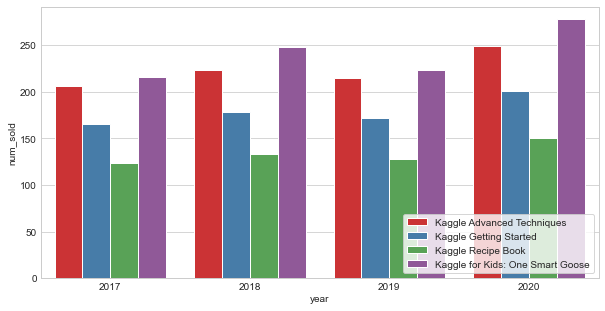

In [33]:
ax = sns.barplot(data=df_train_norm, x='year', y='num_sold', hue='item', ci=None)
plt.legend(loc='lower right')
plt.show()

The distributions are the same by year, there is no difference.

Let's look at the seasonal distribution. Add a new feature characterizing the season.

In [34]:
seasons = {0: 'winter', 1: 'spring', 2: 'summer', 3: 'fall'}

def define_season(v):
    return v % 12 // 3

for _, df in dfs.items():
    df['season'] = define_season(df.month).map(seasons)

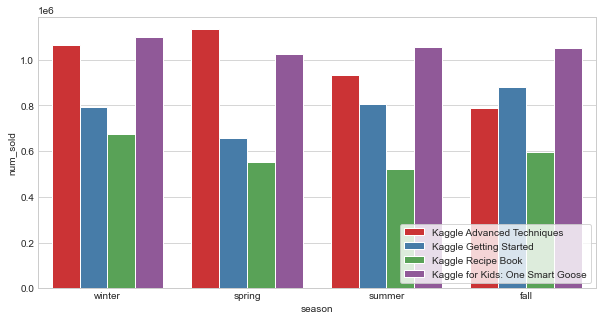

In [35]:
ax = sns.barplot(data=df_train_norm, x='season', y='num_sold', hue='item', estimator=np.sum, ci=None)
plt.legend(loc='lower right')
plt.show()

<!-- Есть некоторые отличия, однако особо полезных инсайтов тут не стоит ожидать. Самая популярная книга в основном -- `Kaggle for Kids`. Лишь весной она уступает `Advanced Techniques`, а зимой продажи этих книг практически равны; `Getting Started` всегда популярнее `Recipe Book`. -->

There is a slight contrast, but especially useful insights are not expected here. The most popular book is basically `Kaggle for Kids`. It gives in to `Advanced Techniques` in the springtime, but the sales of these books are almost equal in winter; `Getting Started` is always more popular than `Recipe Book`.

Now look at the sales' dynamics by the month to get a more complete view.

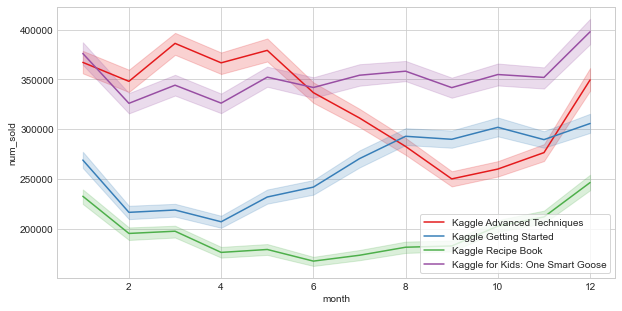

In [36]:
ax = sns.lineplot(data=df_train_norm, x='month', y='num_sold', hue='item', estimator=np.sum)
plt.legend(loc='lower right')
plt.show()

<!-- Здесь мы видим, что все книги обладают разной динамикой сезонности. Так, на протяжении года популярность `Kaggle for Kids` особо не менятся, в то время как, например, во второй половине года (с мая по сентябрь) популярность `Getting Started` растет, а популярность `Advanced Techiques`, наоборот, падает, после чего снова начинает быстро расти. -->

Here we see that all books have different seasonality dynamics. So, throughout the year, the popularity of `Kaggle for Kids` doesn't change much, while, for example, in the second half of the year (from May to September) the popularity of `Getting Started` is growing and in contrast the popularity of `Advanced Techiques` decreases, and then it begins to rise rapidly again.

Edit and save data for modeling

In [37]:
try:
    os.makedirs('data/to_modeling')
except:
    pass

In [38]:
seasons_inv = dict(map(reversed, seasons.items()))
df_train.season = df_train.season.map(seasons_inv)
df_test.season = df_test.season.map(seasons_inv)

stores = {'KaggleMart': 0, 'KaggleRama': 1}
df_train.store = df_train.store.map(stores)
df_test.store = df_test.store.map(stores)

In [39]:
df_train.drop(['date', 'year'], axis=1, inplace=True)
df_test.drop(['date', 'year'], axis=1, inplace=True)

In [40]:
df_train.to_csv('data/to_modeling/train.csv', index=None)
df_test.to_csv('data/to_modeling/test.csv', index=None)